In [2]:
#0: imports

import uproot 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from imports.data import CCV3
from torch_geometric.data import DataLoader 
from imports.models import Net_DE, Net_GAT, Net_Trans
#from imports.model import Net
from torch_geometric.nn import knn_graph

import numpy as np
import awkward as ak
import time
from imports.Agglomerative import Aggloremative

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [27]:
testpath = '/vols/cms/mm1221/Data/100k/5pi/test/'
# Load test data
data_test = CCV3(testpath, max_events=100)
test_loader = DataLoader(data_test, batch_size=1, shuffle=False, follow_batch=['x'])


### Loading data


  0%|                                                                                                                     | 0/1 [00:08<?, ?it/s]

Reached 100!



/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [12]:
print(data_test[0])

Data(x=[133, 8], groups=[133, 3], fractions=[133, 3])


In [ ]:
import matplotlib.pyplot as plt

# Suppose 'df' is your DataFrame with columns: ["x", "y", "z", "E", "eta", "phi", "noh", "layer_id"]
corr_matrix = df.corr()

# Create a standalone figure
plt.figure(figsize=(8,6))  # Adjust figure size as needed

# Plot the correlation matrix with the 'coolwarm' colormap
im = plt.imshow(corr_matrix, origin='lower', aspect='auto', cmap='coolwarm')
plt.colorbar(im)

# Configure tick labels
columns = df.columns
plt.xticks(range(len(columns)), columns, rotation=90)
plt.yticks(range(len(columns)), columns)

# Overlay numerical correlation values in each cell.
# Using white text for high absolute values and black otherwise for readability.
for i in range(len(columns)):
    for j in range(len(columns)):
        text_color = "white" if abs(corr_matrix.iloc[i, j]) > 0.5 else "black"
        plt.text(j, i, f"{corr_matrix.iloc[i, j]:.2f}",
                 ha="center", va="center", color=text_color)

plt.title("Correlation Matrix", pad=20)
plt.tight_layout()

# Uncomment the following line to save the figure at a high resolution
# plt.savefig("correlation_matrix.png", dpi=300)

plt.show()


In [ ]:
# Also load explicitely, used for analysis and plots
data_path = '/vols/cms/mm1221/Data/mix/test/raw/test.root'
#data_path = '/vols/cms/mm1221/Data/100k/5pi/test/raw/test.root' 
data_file = uproot.open(data_path)


MT_ind = data_file['trackstersMerged']['vertices_indexes'].array()
Track_ind = data_file['tracksters']['vertices_indexes'].array()
GT_ind = data_file['simtrackstersCP']['vertices_indexes'].array()
GT_mult = data_file['simtrackstersCP']['vertices_multiplicity'].array()
GT_bc = data_file['simtrackstersCP']['barycenter_x'].array()
energies = data_file['clusters']['energy'].array()
LC_x = data_file['clusters']['position_x'].array()
LC_y = data_file['clusters']['position_y'].array()
LC_z = data_file['clusters']['position_z'].array()
GT_eta = data_file['simtrackstersCP']['barycenter_eta'].array()
GT_regE = data_file['simtrackstersCP']['regressed_energy'].array()

#1.3 Filter so get rid of events with 0 calo particles
t_bx = data_file['tracksters']['barycenter_x'].array()


skim_mask = []
for e in LC_x:
    if 1 <= len(e):
        skim_mask.append(True)
    else:
        skim_mask.append(False)
Track_ind = Track_ind[skim_mask]
GT_ind = GT_ind[skim_mask]
GT_mult = GT_mult[skim_mask]
energies = energies[skim_mask]
LC_x = LC_x[skim_mask]
LC_y = LC_y[skim_mask]
LC_z = LC_z[skim_mask]
MT_ind = MT_ind[skim_mask]
GT_eta = GT_eta[skim_mask]
GT_regE = GT_regE[skim_mask]
pgid = data_file['simtrackstersCP']['pdgID'].array()


skim_mask = []
for e in t_bx:
    if len(e) == 0:
        skim_mask.append(False)
    else:
        skim_mask.append(True)
        
pgid = pgid[skim_mask]





In [ ]:
print(GT_mult[0])

In [ ]:
import awkward as ak

def filter_repeated_indexes(GT_ind, GT_mult):
    """
    Given:
       - GT_ind: an awkward array (or list of lists) of indexes for one event.
       - GT_mult: an awkward array (or list of lists) of multiplicity values (same shape as GT_ind).
    
    For any index that appears in more than one sub-array, keep only the occurrence with the
    smallest multiplicity, and set that multiplicity to 1.0. All other occurrences are removed.
   
    Returns:
       new_GT_ind, new_GT_mult  
         Both are returned as <class 'awkward.highlevel.Array'>.
    """
    # 1. Record all occurrences of each index.
    occurrences = {}
    for sub_i, (sub_ind, sub_mult) in enumerate(zip(GT_ind, GT_mult)):
        for pos, (val, mult) in enumerate(zip(sub_ind, sub_mult)):
            occurrences.setdefault(val, []).append((sub_i, pos, mult))
    
    # 2. Mark occurrences to remove and those to update.
    removals = set()
    update_to_one = set()
    
    for index_val, occ_list in occurrences.items():
        if len(occ_list) > 1:
            occ_list_sorted = sorted(occ_list, key=lambda x: x[2])  # Sort by multiplicity
            kept_occ = occ_list_sorted[0]  # Keep lowest multiplicity
            update_to_one.add((kept_occ[0], kept_occ[1]))
            for occ in occ_list_sorted[1:]:
                removals.add((occ[0], occ[1]))
    
    # 3. Reconstruct new GT_ind and GT_mult by filtering out the removals.
    new_GT_ind = []
    new_GT_mult = []
    for sub_i, (sub_ind, sub_mult) in enumerate(zip(GT_ind, GT_mult)):
        new_sub_ind = []
        new_sub_mult = []
        for pos, (val, mult) in enumerate(zip(sub_ind, sub_mult)):
            if (sub_i, pos) in removals:
                continue
            new_sub_ind.append(val)
            new_sub_mult.append(1.0 if (sub_i, pos) in update_to_one else mult)
        new_GT_ind.append(new_sub_ind)
        new_GT_mult.append(new_sub_mult)
    
    # Convert lists to awkward arrays
    return ak.Array(new_GT_ind), ak.Array(new_GT_mult)

def filter_repeated_indexes_for_events(all_GT_ind, all_GT_mult):
    """
    Given a list of events, each with its GT_ind and GT_mult (lists of sub-arrays),
    apply filter_repeated_indexes to each event.
    
    Args:
        all_GT_ind: List of events. Each event is an awkward array (or list of sub-arrays) of indexes.
        all_GT_mult: List of events. Each event is an awkward array (or list of sub-arrays) of multiplicity values.
    
    Returns:
        new_all_GT_ind, new_all_GT_mult: Awkward arrays (one per event) of filtered GT_ind and GT_mult.
    """
    new_all_GT_ind = []
    new_all_GT_mult = []
    
    # Loop over each event
    for event_ind, event_mult in zip(all_GT_ind, all_GT_mult):
        new_event_ind, new_event_mult = filter_repeated_indexes(event_ind, event_mult)
        new_all_GT_ind.append(new_event_ind)
        new_all_GT_mult.append(new_event_mult)
    
    # Convert to awkward arrays
    return ak.Array(new_all_GT_ind), ak.Array(new_all_GT_mult)

GT_ind_nodup, GT_mult_nodup = filter_repeated_indexes_for_events(GT_ind, GT_mult)

import awkward as ak

import awkward as ak

# Create new lists to store the filtered results
# This makes sure GT_ind, MT_ind, Recon_ind have the same indices
filtered_GT_ind = []
filtered_GT_mult = []
filtered_MT_ind = []


for event_idx, track_indices in enumerate(data_test.stsCP_vertices_indexes):
    # Flatten the current event's track indices and convert to a set
    track_flat = set(ak.flatten(track_indices).tolist())  # Ensure it contains only integers
    
    # Filter GT_ind and GT_mult for the current event, preserving structure
    event_GT_ind = GT_ind[event_idx]
    event_GT_mult = GT_mult[event_idx]
    filtered_event_GT_ind = []
    filtered_event_GT_mult = []
    for sublist_ind, sublist_mult in zip(event_GT_ind, event_GT_mult):
        filtered_sublist_ind = [idx for idx in sublist_ind if idx in track_flat]
        filtered_sublist_mult = [mult for idx, mult in zip(sublist_ind, sublist_mult) if idx in track_flat]
        filtered_event_GT_ind.append(filtered_sublist_ind)
        filtered_event_GT_mult.append(filtered_sublist_mult)

    # Filter MT_ind for the current event, preserving structure
    event_MT_ind = MT_ind[event_idx]
    filtered_event_MT_ind = []
    for sublist in event_MT_ind:
        filtered_sublist = [idx for idx in sublist if idx in track_flat]
        filtered_event_MT_ind.append(filtered_sublist)

    # Append filtered results
    filtered_GT_ind.append(filtered_event_GT_ind)
    filtered_GT_mult.append(filtered_event_GT_mult)
    filtered_MT_ind.append(filtered_event_MT_ind)

# Convert the filtered results back to awkward arrays
GT_ind_filt = ak.Array(filtered_GT_ind)
GT_mult_filt = ak.Array(filtered_GT_mult)
MT_ind_filt = ak.Array(filtered_MT_ind)

# Create new lists to store the filtered results
# This makes sure GT_ind, MT_ind, Recon_ind have the same indices
filtered_GT_ind_nodup = []
filtered_GT_mult_nodup = []



for event_idx, track_indices in enumerate(data_test.stsCP_vertices_indexes):
    # Flatten the current event's track indices and convert to a set
    track_flat = set(ak.flatten(track_indices).tolist())  # Ensure it contains only integers
    
    # Filter GT_ind and GT_mult for the current event, preserving structure
    event_GT_ind = GT_ind_nodup[event_idx]
    event_GT_mult = GT_mult_nodup[event_idx]
    filtered_event_GT_ind = []
    filtered_event_GT_mult = []
    for sublist_ind, sublist_mult in zip(event_GT_ind, event_GT_mult):
        filtered_sublist_ind = [idx for idx in sublist_ind if idx in track_flat]
        filtered_sublist_mult = [mult for idx, mult in zip(sublist_ind, sublist_mult) if idx in track_flat]
        filtered_event_GT_ind.append(filtered_sublist_ind)
        filtered_event_GT_mult.append(filtered_sublist_mult)



    # Append filtered results
    filtered_GT_ind_nodup.append(filtered_event_GT_ind)
    filtered_GT_mult_nodup.append(filtered_event_GT_mult)


# Convert the filtered results back to awkward arrays
GT_ind_filt_nodup = ak.Array(filtered_GT_ind_nodup)
GT_mult_filt_nodup = ak.Array(filtered_GT_mult_nodup)





In [42]:

model = Net_DE(128,3, dropout=0.3, contrastive_dim=16, k=64)
#checkpoint= torch.load('/vols/cms/mm1221/hgcal/Mixed/LC/Fraction/runs/DEC/hd128nl3cd128k72/best_model.pt',  map_location=torch.device('cpu'))
checkpoint= torch.load('/vols/cms/er421/hgcal/code/code/Mixed/LC/Full/results/hd128nl3cd16k64/epoch-100.pt',  map_location=torch.device('cpu'))
#model.load_state_dict(checkpoint['model'])  
model.eval() 


Net_DE(
  (lc_encode): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ELU(alpha=1.0)
  )
  (edgeconv_layers): ModuleList(
    (0-2): 3 x DynamicEdgeConv(nn=Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=128, out_features=128, bias=True)
    ), k=64)
  )
  (output): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ELU(alpha=1.0)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ELU(alpha=1.0)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=32, out_features=16, bias=True)
  )
)

In [ ]:
import numpy as np
from sklearn.cluster import AffinityPropagation

def affinity_propagation_clustering(all_predictions, damping=0.9, preference=None, affinity='euclidean'):
    """
    Perform Affinity Propagation clustering on each set of embeddings in all_predictions.
    
    Parameters
    ----------
    all_predictions : list or ndarray
        A list or array of arrays, where each inner array has shape [n_points, n_features].
    damping : float, default=0.9
        Damping factor between 0.5 and 1 to avoid numerical oscillations.
    preference : float or array-like, default=None
        Preferences for each point – if None, the median of the input similarities is used.
    affinity : str, default='euclidean'
        Which affinity to use. When set to 'euclidean', the algorithm computes similarities as the negative squared Euclidean distances.
    
    Returns
    -------
    all_cluster_labels : ndarray
        2D array of shape (num_sets, n_points_in_set) containing cluster labels for each set.
    """
    
    all_cluster_labels = []
    
    for i, pred in enumerate(all_predictions):
        if len(pred) < 2:
            # For a single (or zero) data point, assign a default cluster label
            cluster_labels = np.ones(len(pred), dtype=int)
        else:
            clustering = AffinityPropagation(damping=damping, preference=preference, affinity=affinity)
            cluster_labels = clustering.fit_predict(pred)
        all_cluster_labels.append(cluster_labels)
    
    return np.array(all_cluster_labels)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import MeanShift, estimate_bandwidth

def mean_shift_clustering(all_predictions, bandwidth=None, quantile=0.3, n_samples=None):
    """
    Perform Mean Shift clustering on each set of embeddings in all_predictions.
    If bandwidth is not provided, it will be estimated from the data using
    sklearn's estimate_bandwidth.

    Parameters
    ----------
    all_predictions: list or ndarray
        List or array of arrays, where each inner array has shape [n_points, n_features].
    bandwidth : float, optional
        Bandwidth used in the RBF kernel. If None, it is estimated from data.
    quantile : float, optional
        Quantile used to compute the bandwidth if bandwidth is None.
    n_samples : int, optional
        Number of samples to use when estimating bandwidth if bandwidth is None.

    Returns
    -------
    all_cluster_labels : ndarray
        2D array of shape (num_sets, n_points_in_set) containing cluster labels for each set.
    """

    all_cluster_labels = []

    for i, pred in enumerate(all_predictions):
        if len(pred) < 2:
            # If there is only one (or zero) data point, assign it to cluster 1
            cluster_labels = np.ones(len(pred), dtype=int)
        else:
            # Optionally estimate bandwidth if not provided
            if bandwidth is None:
                bw_value = estimate_bandwidth(pred, quantile=quantile, n_samples=n_samples)
            else:
                bw_value = bandwidth

            # Perform Mean Shift clustering
            ms = MeanShift(bandwidth=bw_value)
            cluster_labels = ms.fit_predict(pred)

        all_cluster_labels.append(cluster_labels)

    return np.array(all_cluster_labels)


In [43]:
import time
import numpy as np
from sklearn.metrics.pairwise import cosine_distances  # for cosine distance calculation

all_predictions = []  
start_time = time.time()

# Get predictions for each event
for i, data in enumerate(test_loader):
    #edge_index = knn_graph(data.x[:, :3], k=98, batch=data.x_batch)
    if i >10:
        break
    
    predictions = model(data.x,data.x_batch)
    all_predictions.append(predictions[0].detach().cpu().numpy())  

all_predictions = np.array(all_predictions)

# 3.2: Cluster using threshold found in Script A
all_cluster_labels = Aggloremative(all_predictions, threshold=0.175)
#all_cluster_labels = affinity_propagation_clustering(all_predictions, damping=0.6)
"""
all_cluster_labels = mean_shift_clustering(
    all_predictions,
    bandwidth=None,    # Or a numeric value if you already have a good estimate
    quantile=0.2,      # Tweak quantile to control bandwidth estimation
    n_samples=500      # You can limit the sample size if data is large
)
"""

end_time = time.time()

# 3.3: Calculate average inference time
time_diff = end_time - start_time
inference_time = time_diff / len(all_cluster_labels)
print("average inference time:", inference_time)


average inference time: 0.0683145523071289


/tmp/ipykernel_3806228/3398092132.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', num_groups)


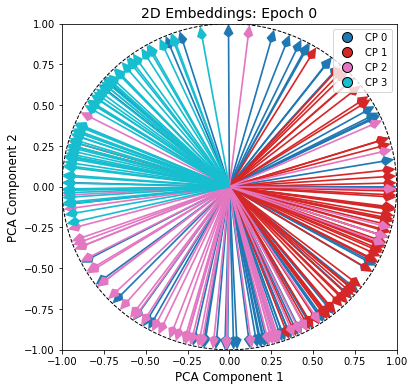

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.lines as mlines
from sklearn.decomposition import PCA

event = 8
# --- 1. Prepare the data ---
event_predictions = all_predictions[event]
if event_predictions.ndim == 1:
    event_predictions = event_predictions.reshape(1, -1)

# --- 2. Dimensionality reduction ---
pca = PCA(n_components=2)
event_2d = pca.fit_transform(event_predictions)

# Normalize each 2D vector to unit length.
norms = np.linalg.norm(event_2d, axis=1, keepdims=True)
norms[norms == 0] = 1  # Avoid division by zero.
event_normalized = event_2d / norms

# --- 3. Determine group membership using data_test[event].assoc ---
# data_test[event].assoc is assumed to be a list/array of integers (one per node).
group_labels = np.array(data_test[event].assoc).astype(int)
# Number of groups (assuming labels start at 0)
num_groups = int(np.max(group_labels)) + 1

# Choose a colormap.
if num_groups <= 10:
    cmap = plt.cm.get_cmap('tab10', num_groups)
else:
    cmap = plt.cm.get_cmap('tab20', num_groups)

# --- 4. Plotting ---
fig, ax = plt.subplots(figsize=(6, 6))

# Plot each unit vector as an arrow from the origin with larger arrow heads.
for i, vec in enumerate(event_normalized):
    color = cmap(group_labels[i]) if group_labels[i] != -1 else 'gray'
    ax.quiver(0, 0, vec[0], vec[1],
              angles='xy', scale_units='xy', scale=1, width=0.005,
              color=color, headwidth=6, headlength=6, headaxislength=8)

# Draw a dashed circle representing the unit circle (in black).
circle = plt.Circle((0, 0), 1, color='black', fill=False, linestyle='--', linewidth=1)
ax.add_artist(circle)

# Set axis limits.
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

# Add axis labels and title.
ax.set_xlabel('PCA Component 1', fontsize=12)
ax.set_ylabel('PCA Component 2', fontsize=12)
ax.set_title('2D Embeddings: Epoch 0', fontsize=14)

# --- Custom legend handles (with fixed marker sizes) ---
legend_handles = []
for group_id in range(num_groups):
    handle = mlines.Line2D([], [], marker='o', color='w',
                           markerfacecolor=cmap(group_id),
                           markeredgecolor='k',
                           markersize=10, label=f'CP {group_id}')
    legend_handles.append(handle)
if np.any(group_labels == -1):
    handle = mlines.Line2D([], [], marker='o', color='w',
                           markerfacecolor='gray',
                           markeredgecolor='k',
                           markersize=10, label='Not assigned')
    legend_handles.append(handle)

ax.legend(handles=legend_handles, loc='upper right')
plt.savefig("Pre.pdf")
plt.show()


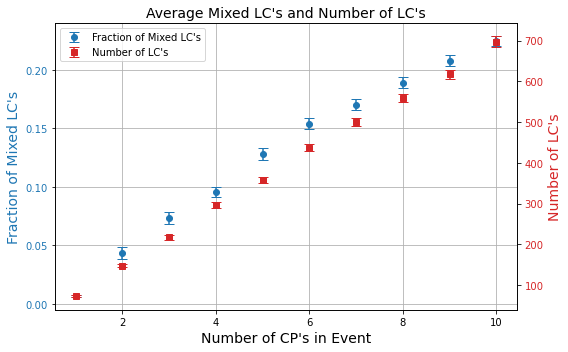

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Create dictionaries to accumulate fractions and node counts by number of unique groups (1 to 10)
group_fraction_dict = {i: [] for i in range(1, 11)}
group_nodes_dict = {i: [] for i in range(1, 11)}

# Loop over each event in data_test
for event in data_test:
    # Extract initial values from the fractions tensor (first column)
    initial_values = event.fractions[:, 0]
    
    # Count the total number of nodes in the event
    total_nodes = event.fractions.size(0)
    
    # Skip this event if there are no nodes to avoid division by zero
    if total_nodes == 0:
        continue
    
    # Determine which nodes are split (initial value < 0.8)
    split_mask = initial_values < 0.8
    
    # Count the number of split nodes
    split_count = split_mask.sum().item()
    
    # Calculate the fraction of split nodes for the event
    fraction_split = split_count / total_nodes
    
    # Compute the number of unique groups in the event
    num_groups = event.groups.unique().numel()
    
    # Only accumulate data if number of groups is between 1 and 10
    if 1 <= num_groups <= 10:
        group_fraction_dict[num_groups].append(fraction_split)
        group_nodes_dict[num_groups].append(total_nodes)

# Prepare lists for group counts (x-axis), averages, and error bars
group_counts = []
avg_fraction_split = []
frac_std_err = []
avg_num_nodes = []
nodes_std_err = []

# For each group count from 1 to 10, compute averages and standard errors
for groups in range(1, 11):
    group_counts.append(groups)
    
    fractions = group_fraction_dict[groups]
    if fractions:
        avg_frac = np.mean(fractions)
        se_frac = np.std(fractions, ddof=1) / np.sqrt(len(fractions)) if len(fractions) > 1 else 0
    else:
        avg_frac = 0
        se_frac = 0
    avg_fraction_split.append(avg_frac)
    frac_std_err.append(se_frac)
    
    nodes = group_nodes_dict[groups]
    if nodes:
        avg_nodes = np.mean(nodes)
        se_nodes = np.std(nodes, ddof=1) / np.sqrt(len(nodes)) if len(nodes) > 1 else 0
    else:
        avg_nodes = 0
        se_nodes = 0
    avg_num_nodes.append(avg_nodes)
    nodes_std_err.append(se_nodes)

# Create the plot with two y-axes
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot error bars for the fraction of split nodes
ax1.errorbar(group_counts, avg_fraction_split, yerr=frac_std_err, fmt='o', capsize=5, label="Fraction of Mixed LC's")
ax1.set_xlabel("Number of CP's in Event", fontsize=14)
ax1.set_ylabel("Fraction of Mixed LC's", color='tab:blue', fontsize=14)
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_title("Average Mixed LC's and Number of LC's", fontsize=14)
ax1.grid(True)

# Second y-axis for average number of nodes
ax2 = ax1.twinx()
ax2.errorbar(group_counts, avg_num_nodes, yerr=nodes_std_err, fmt='s', capsize=5, color='tab:red', label="Number of LC's")
ax2.set_ylabel("Number of LC's", color='tab:red', fontsize=14)
ax2.tick_params(axis='y', labelcolor='tab:red')

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

fig.tight_layout()
plt.savefig("")
plt.show()


In [ ]:
print(avg_fraction_split)

In [ ]:
import torch
import numpy as np
from sklearn.neighbors import NearestNeighbors

# Lists to accumulate total edge counts and edge counts with at least one mixed node
edges_total_list = []
edges_with_mixed_list = []

# Filter events to only include those with exactly 10 unique groups.
# (Assuming that event.groups is a tensor where each row gives the group assignment vector for that node.)
events_10_groups = [event for event in data_test if event.groups.unique().numel() == 10]

# Process each event that meets the criterion
for event in events_10_groups:
    # Get the x, y, z coordinates from event.x (first 3 columns) and convert to a NumPy array
    coords = event.x[:, :3].cpu().numpy()
    
    # Build the kNN graph: request k=65 neighbors so that the first neighbor (self) can be removed.
    nbrs = NearestNeighbors(n_neighbors=65, algorithm='ball_tree').fit(coords)
    distances, indices = nbrs.kneighbors(coords)
    
    # Remove the self-edge by discarding the first column (each node is its own nearest neighbor)
    knn_indices = indices[:, 1:]  # shape: [num_nodes, 64]
    
    num_nodes = coords.shape[0]
    total_edges = num_nodes * 64  # each node yields 64 directed edges
    
    # Create a boolean mask of mixed nodes.
    # Here, a node is defined as "mixed" if its first fraction value is less than 0.8.
    fractions_np = event.fractions[:, 0].cpu().numpy()
    mixed_mask = fractions_np < 0.8
    
    # Count edges that contain at least one mixed node.
    # For each node i (the source):
    #   - If the source node is mixed, count all its 64 outgoing edges.
    #   - Otherwise, count how many of its 64 neighbors are mixed.
    mixed_edge_count = 0
    for i in range(num_nodes):
        if mixed_mask[i]:
            mixed_edge_count += 64
        else:
            mixed_edge_count += np.sum(mixed_mask[knn_indices[i]])
    
    # Append counts for this event
    edges_total_list.append(total_edges)
    edges_with_mixed_list.append(mixed_edge_count)

# Compute average total edges and average mixed edges over all 10-group events
avg_total_edges = np.mean(edges_total_list) if edges_total_list else 0
avg_edges_mixed = np.mean(edges_with_mixed_list) if edges_with_mixed_list else 0

print(f"Average total edges for 10-group events: {avg_total_edges:.2f}")
print(f"Average edges with at least one mixed node: {avg_edges_mixed:.2f}")


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import torch
import torch.nn.functional as F

# ---------------------------------------------
# Helper: compute cosine similarities for a list of edges
def compute_cosine_similarities(embeddings, edge_indices, skip_self=True):
    """
    embeddings: NumPy array of shape [N, D]
    edge_indices: list of [src, tgt]
    skip_self: whether to skip edges where src == tgt
    """
    sims = []
    for edge in edge_indices:
        src, tgt = edge
        if skip_self and src == tgt:
            continue
        # Cosine similarity for these two rows
        sim = cosine_similarity(embeddings[[src, tgt], :])[0, 1]
        sims.append(sim)
    return np.array(sims)

# ---------------------------------------------
# Build pos & neg edges from data_test[i].assoc
def build_edges_from_assoc(data_item):
    """
    data_item.assoc: array of length N specifying a group ID for each node in the event.
    We assume data_item.assoc[n] is an integer: the group ID of node n.
    """
    group_ids = data_item.assoc
    N = len(group_ids)

    pos_edges = []
    neg_edges = []

    # Generate all unique pairs i < j
    for i in range(N):
        for j in range(i + 1, N):
            if group_ids[i] == group_ids[j]:
                pos_edges.append([i, j])
            else:
                neg_edges.append([i, j])

    return pos_edges, neg_edges

# ---------------------------------------------
num_events = 100  # Example: process the first 10 events
all_pos_sims = []
all_neg_sims = []

for i in tqdm(range(num_events), desc="Processing events"):
    # 'all_predictions[i]' is shape [N, embedding_dim],
    # matching the length of data_test[i].assoc
    pred_tensor = torch.tensor(all_predictions[i], dtype=torch.float32)
    # Normalize embeddings
    pred_norm = F.normalize(pred_tensor, p=2, dim=1)
    embeddings = pred_norm.cpu().numpy()

    # Build positive & negative edges based on group IDs
    pos_edge_indices, neg_edge_indices = build_edges_from_assoc(data_test[i])

    # Compute similarities
    pos_sims = compute_cosine_similarities(embeddings, pos_edge_indices, skip_self=True)
    neg_sims = compute_cosine_similarities(embeddings, neg_edge_indices, skip_self=True)

    # Accumulate for global stats
    all_pos_sims.extend(pos_sims.tolist())
    all_neg_sims.extend(neg_sims.tolist())

all_pos_sims_hard = np.array(all_pos_sims)
all_neg_sims_hard = np.array(all_neg_sims)

mean_pos_sim = np.mean(all_pos_sims)
mean_neg_sim = np.mean(all_neg_sims)

print(f"Mean Positive Edge Cosine Similarity: {mean_pos_sim:.4f}")
print(f"Mean Negative Edge Cosine Similarity: {mean_neg_sim:.4f}")



Processing events: 100%|██████████████████████| 100/100 [17:46<00:00, 10.67s/it]


Mean Positive Edge Cosine Similarity: 0.9550
Mean Negative Edge Cosine Similarity: 0.6252


KeyboardInterrupt: 

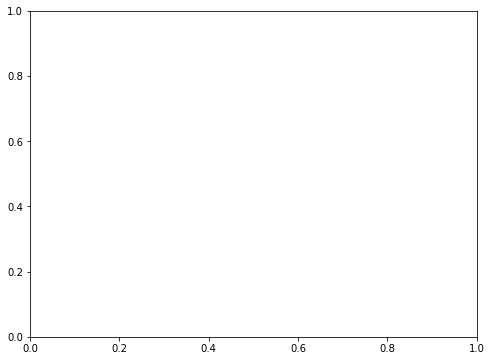

In [11]:
import matplotlib.pyplot as plt

# Suppose we already have these arrays:
# all_pos_sims_hard (for F-NTXENT positive)
# all_neg_sims_hard (for F-NTXENT negative)

plt.figure(figsize=(8, 6))

plt.hist(all_pos_sims, bins=50, histtype="step", linewidth=2, label="F-NTXENT Positive")
plt.hist(all_neg_sims, bins=50, histtype="step", linewidth=2, label="F-NTXENT Negative")

plt.xlim(-1, 1)  # range of cosine similarity
plt.xlabel("Cosine Similarity", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("F-NTXENT Distribution", fontsize=16)
plt.legend()

plt.tight_layout()
plt.savefig("FNT.pdf")
plt.show()


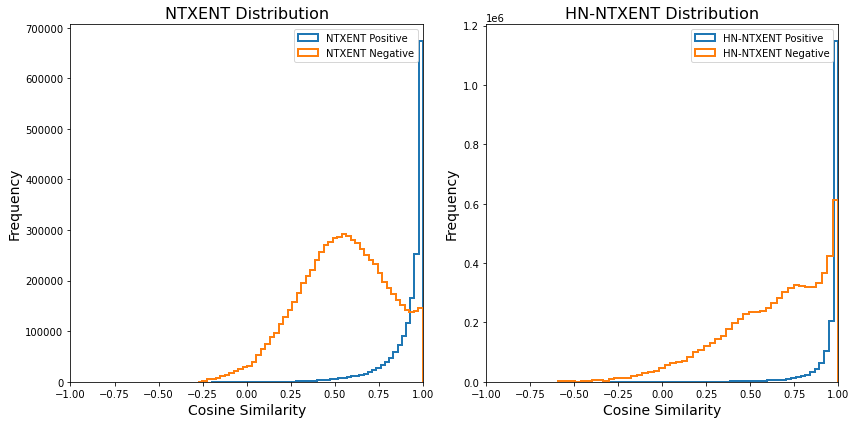

In [10]:
import matplotlib.pyplot as plt

# Suppose we already have these arrays:
# all_pos_sims, all_neg_sims (for NTXENT)
# all_pos_sims_HN, all_neg_sims_HN (for HNNTXENT)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# ------------------------------------------------------
# Left subplot: NTXENT
axs[0].hist(all_pos_sims_no, bins=50, histtype="step", linewidth=2, label="NTXENT Positive")
axs[0].hist(all_neg_sims_no, bins=50, histtype="step", linewidth=2, label="NTXENT Negative")

axs[0].set_xlim(-1, 1)  # range of cosine similarity
axs[0].set_xlabel("Cosine Similarity", fontsize=14)
axs[0].set_ylabel("Frequency", fontsize=14)
axs[0].set_title("NTXENT Distribution", fontsize=16)
axs[0].legend()

# ------------------------------------------------------
# Right subplot: HNNTXENT
axs[1].hist(all_pos_sims_hard, bins=50, histtype="step", linewidth=2, label="HN-NTXENT Positive")
axs[1].hist(all_neg_sims_hard, bins=50, histtype="step", linewidth=2, label="HN-NTXENT Negative")

axs[1].set_xlim(-1, 1)  # range of cosine similarity
axs[1].set_xlabel("Cosine Similarity", fontsize=14)
axs[1].set_ylabel("Frequency", fontsize=14)
axs[1].set_title("HN-NTXENT Distribution", fontsize=16)
axs[1].legend()

plt.savefig("cosine.pdf")
plt.tight_layout()
plt.show()


In [ ]:
#4: Calculate Scores and create DF for our model and TICL

#4.1: Turn the cluster labels into our reconstructed tracksters

recon_ind = []

for event_idx, labels in enumerate(all_cluster_labels):
    event_clusters = {} 
    for cluster_idx, cluster_label in enumerate(labels):
        if cluster_label not in event_clusters:
            event_clusters[cluster_label] = []
        event_clusters[cluster_label].append(ak.flatten(data_test.stsCP_vertices_indexes[event_idx])[cluster_idx])
    recon_ind.append([event_clusters[label] for label in sorted(event_clusters.keys())])

recon_ind = ak.Array(recon_ind)
recon_mult = ak.Array([[[1 for _ in sublist] for sublist in event] for event in recon_ind]) # keep variable for future
# endeavours where the model is able to assign multiple caloparticles to a LC.
Track_mult = ak.Array([[[1 for _ in sublist] for sublist in event] for event in Track_ind]) # keep variable for future
MT_mult_filt = ak.Array([[[1 for _ in sublist] for sublist in event] for event in MT_ind_filt]) # keep variable for future

In [ ]:
from tqdm import tqdm
def calculate_sim_to_reco_score(CaloParticle, energies_indices, ReconstructedTrackster, track_mult, calo_mult):
    """
    Calculate the sim-to-reco score for a given CaloParticle and ReconstructedTrackster.
    
    Parameters:
    - CaloParticle: array of Layer Clusters in the CaloParticle.
    - Multiplicity: array of Multiplicity for layer clusters in CP
    - energies_indices: array of energies associated with all LC (indexed by LC).
    - ReconstructedTrackster: array of LC in the reconstructed Trackster.
    
    Returns:
    - sim_to_reco_score: the calculated sim-to-reco score.
    """
    numerator = 0.0
    denominator = 0.0

    # Iterate over all DetIds in the CaloParticle
    for i, det_id in enumerate(CaloParticle):
        energy_k = energies_indices[det_id]  # Energy for the current DetId in CaloParticle
        
        # Fraction of energy in the Trackster (fr_k^TST)
        if det_id in ReconstructedTrackster:
            index = np.where(ReconstructedTrackster == det_id)[0][0]
            fr_tst_k = 1 / track_mult[index]
            
        else:
            fr_tst_k = 0 # binary function also for CaloParticle

        # Fraction of energy in the CaloParticle (fr_k^SC)
        fr_sc_k = 1 / calo_mult[i]

        # Update numerator using the min function
        numerator += min(
            (fr_sc_k - fr_tst_k) ** 2,  # First term in the min function
            fr_sc_k ** 2                # Second term in the min function
        ) * (energy_k ** 2)

        # Update denominator
        denominator += (fr_sc_k ** 2) * (energy_k ** 2)


    # Calculate score
    sim_to_reco_score = numerator / denominator if denominator != 0 else 1.0
    return sim_to_reco_score

def calculate_reco_to_sim_score_and_sharedE(ReconstructedTrackster, energies_indices, CaloParticle, track_mult, calo_mult):
    """
    Calculate the reco-to-sim score for a given ReconstructedTrackster and CaloParticle.

    Parameters:
    - ReconstructedTrackster: array of DetIds in the ReconstructedTrackster.
    - energies_indices: array of energies associated with all DetIds (indexed by DetId).
    - CaloParticle: array of DetIds in the CaloParticle.

    Returns:
    - reco_to_sim_score: the calculated reco-to-sim score.
    """
    numerator = 0.0
    denominator = 0.0
    sharedEnergy = 0.0

    # Iterate over all DetIds in the ReconstructedTrackster
    for i, det_id in enumerate(ReconstructedTrackster):
        energy_k = energies_indices[det_id]  # Energy for the current DetId in the Trackster
        
        # Fraction of energy in the Trackster (fr_k^TST)
        fr_tst_k = 1 / track_mult[i]

        #Fraction of energy in the caloparticle
        if det_id in CaloParticle:
            index = np.where(CaloParticle == det_id)[0][0]
            fr_sc_k = 1 / calo_mult[index]
            
        else:
            fr_sc_k = 0 # binary function also for CaloParticle
            
        # Update numerator using the min function
        numerator += min(
            (fr_tst_k - fr_sc_k) ** 2,  # First term in the min function
            fr_tst_k ** 2               # Second term in the min function
        ) * (energy_k ** 2)

        # Update denominator
        denominator += (fr_tst_k ** 2) * (energy_k ** 2)
        
        #shared_energy calculation
        recosharedEnergy = energy_k * fr_tst_k
        simsharedEnergy = energy_k * fr_sc_k
        sharedEnergy += min(simsharedEnergy,recosharedEnergy)
        
        

    # Calculate score
    reco_to_sim_score = numerator / denominator if denominator != 0 else 1.0
    return reco_to_sim_score, sharedEnergy


def calculate_all_event_scores(GT_ind, GT_mult, GT_regE, energies, recon_ind, recon_mult,GT_eta, num_events = 100):
    """
    Calculate sim-to-reco and reco-to-sim scores for all CaloParticle and ReconstructedTrackster combinations across all events.

    Parameters:
    - GT_ind: List of CaloParticle indices for all events.
    - energies: List of energy arrays for all events.
    - recon_ind: List of ReconstructedTrackster indices for all events.
    - LC_x, LC_y, LC_z, LC_eta: Lists of x, y, z positions and eta values for all DetIds across events.

    Returns:
    - DataFrame containing scores and additional features for each CaloParticle-Trackster combination across all events.
    """
    # Initialize an empty list to store results
    all_results = []

    # Loop over all events with a progress bar
    for event_index in tqdm(range(num_events)):
        caloparticles = GT_ind[event_index]  # Indices for all CaloParticles in the event
        tracksters = recon_ind[event_index]  # Indices for all ReconstructedTracksters in the event
        event_energies = energies[event_index]  # Energies for this event
        event_GT_mult = GT_mult[event_index]
        event_recon_mult = recon_mult[event_index]
        event_GT_regE = GT_regE[event_index]
        event_GT_eta = GT_eta[event_index]

        
        # Loop over all CaloParticles
        for calo_idx, caloparticle in enumerate(caloparticles):
            calo_mult = event_GT_mult[calo_idx]
            cp_raw_energy_lc = event_energies[caloparticle] / calo_mult
            cp_raw_energy = np.sum(cp_raw_energy_lc)
            cp_regressed_energy = event_GT_regE[calo_idx]
            cp_eta = event_GT_eta[calo_idx]
            
            for trackster_idx, trackster in enumerate(tracksters):
                track_mult = event_recon_mult[trackster_idx]
                
                # Calculate sim-to-reco score
                sim_to_reco_score = calculate_sim_to_reco_score(caloparticle, event_energies, trackster, track_mult, calo_mult)
                
                # Calculate reco-to-sim score
                reco_to_sim_score, shared_energy = calculate_reco_to_sim_score_and_sharedE(trackster, event_energies, caloparticle, track_mult, calo_mult)
                # Calculate trackster energy
                trackster_energy_lc = event_energies[trackster] / track_mult
                trackster_energy = np.sum(trackster_energy_lc)

                # Append results
                all_results.append({
                    "event_index": event_index,
                    "cp_id": calo_idx,
                    "trackster_id": trackster_idx,
                    "sim_to_reco_score": sim_to_reco_score,
                    "reco_to_sim_score": reco_to_sim_score,
                    "cp_energy": cp_raw_energy,
                    "cp_regressed_energy": cp_regressed_energy,
                    "trackster_energy": trackster_energy,
                    "shared_energy": shared_energy,
                    "cp_eta": cp_eta
                })

    # Convert results to a DataFrame
    df = pd.DataFrame(all_results)
    return df

In [ ]:
df_CL = calculate_all_event_scores(GT_ind_filt, GT_mult_filt, GT_regE, energies, recon_ind, recon_mult,GT_eta, num_events = 100)
#df_TICL = calculate_all_event_scores(GT_ind_filt, GT_mult_filt, GT_regE, energies, Track_ind, Track_mult,GT_eta, num_events = 50)

In [ ]:
df_CL = pd.read_csv("df_DE_mix_0165.csv")
df_Track = pd.read_csv("df_TICL_track.csv")
df_MT = pd.read_csv("df_TICL_MT.csv")

In [ ]:
df_CL['pgid'] = df_CL.apply(lambda row: pgid[int(row['event_index'])][int(row['cp_id'])], axis=1)
df_Track['pgid'] = df_Track.apply(lambda row: pgid[int(row['event_index'])][int(row['cp_id'])], axis=1)
df_MT['pgid'] = df_MT.apply(lambda row: pgid[int(row['event_index'])][int(row['cp_id'])], axis=1)

In [ ]:
def calculate_metrics(df, model_name):
    # Filter to only include rows with pgid == 211.
    #df = df[df['pgid'] == 211].copy()
    
    # ----- Efficiency Calculation -----
    # Step 1: Filter out rows where 'cp_id' is NaN
    cp_valid = df.dropna(subset=['cp_id']).copy()

    # Step 2: Group by 'event_index' and 'cp_id' to process each CaloParticle individually
    cp_grouped = cp_valid.groupby(['event_index', 'cp_id'])

    # Step 3: For each CaloParticle, check if any 'shared_energy' >= 50% of 'cp_energy'
    def is_cp_associated(group):
        cp_energy = group['cp_energy'].iloc[0]  # Assuming 'cp_energy' is consistent within the group
        threshold = 0.5 * cp_energy
        return (group['shared_energy'] >= threshold).any()

    # Apply the association function to each group
    cp_associated = cp_grouped.apply(is_cp_associated)

    # Step 4: Calculate the number of associated CaloParticles and total CaloParticles
    num_associated_cp = cp_associated.sum()
    total_cp = cp_associated.count()
    efficiency = num_associated_cp / total_cp if total_cp > 0 else 0

    # ----- Purity Calculation -----
    tst_valid = df.dropna(subset=['trackster_id']).copy()
    tst_grouped = tst_valid.groupby(['event_index', 'trackster_id'])

    # A Trackster is "associated" if reco_to_sim_score < 0.2 for at least one CP
    tst_associated = tst_grouped['reco_to_sim_score'].min() < 0.2
    num_associated_tst = tst_associated.sum()
    total_tst = tst_associated.count()
    purity = num_associated_tst / total_tst if total_tst > 0 else 0

    # ----- Containment Calculation -----
    #  (similar approach, but now we look at Sim-to-Reco < 0.2)
    cp_valid_cont = df.dropna(subset=['cp_id']).copy()
    cp_grouped_cont = cp_valid_cont.groupby(['event_index', 'cp_id'])
    cp_associated_cont = cp_grouped_cont['sim_to_reco_score'].min() < 0.2
    num_associated_cp_cont = cp_associated_cont.sum()
    total_cp_cont = cp_associated_cont.count()
    containment = num_associated_cp_cont / total_cp_cont if total_cp_cont > 0 else 0

    # ----- Duplicate Rate -----
    # Number of simulated objects (CaloParticles) that have been associated (Sim-to-Reco < 0.2)
    # to multiple Tracksters, divided by the total number of simulated objects.
    cp_grouped_dup = cp_valid.groupby(['event_index', 'cp_id'])

    def get_associated_tracksters_cp(group):
        # Return the unique Trackster IDs for which sim_to_reco_score < 0.2
        return group[group['sim_to_reco_score'] < 0.2]['trackster_id'].unique()

    cp_associated_tracksters = cp_grouped_dup.apply(get_associated_tracksters_cp)

    # A CP is "duplicated" if it's associated with more than one Trackster
    duplicate_count = (cp_associated_tracksters.apply(lambda x: len(x) > 1)).sum()
    total_cp_dup = len(cp_associated_tracksters)
    duplicate_rate = duplicate_count / total_cp_dup if total_cp_dup > 0 else 0

    # ----- Merge Rate -----
    # Number of reconstructed objects (Tracksters) that have been associated (Reco-to-Sim < 0.2)
    # to multiple simulated objects, divided by the total number of reconstructed objects.
    tst_grouped_merge = tst_valid.groupby(['event_index', 'trackster_id'])

    def get_associated_cps_tst(group):
        # Return the unique CP IDs for which reco_to_sim_score < 0.2
        return group[group['reco_to_sim_score'] < 0.2]['cp_id'].unique()

    tst_associated_cps = tst_grouped_merge.apply(get_associated_cps_tst)

    # A Trackster is "merged" if it's associated with more than one CP
    merge_count = (tst_associated_cps.apply(lambda x: len(x) > 1)).sum()
    total_tst_merge = len(tst_associated_cps)
    merge_rate = merge_count / total_tst_merge if total_tst_merge > 0 else 0

    # Print results for the model
    print(f"\nModel: {model_name}")
    print(f"Efficiency:  {efficiency:.4f} ({num_associated_cp} / {total_cp})")
    print(f"Containment: {containment:.4f} ({num_associated_cp_cont} / {total_cp_cont})")
    print(f"Purity:      {purity:.4f} ({num_associated_tst} / {total_tst})")
    print(f"Duplicate Rate: {duplicate_rate:.4f} ({duplicate_count} CPs out of {total_cp_dup} total)")
    print(f"Merge Rate:     {merge_rate:.4f} ({merge_count} Tracksters out of {total_tst_merge} total)")
    print(f"Num tracksters ratio: {total_tst / total_cp if total_cp > 0 else 0:.4f}")

    return {
        'efficiency': efficiency,
        'purity': purity,
        'containment': containment,
        'duplicate_rate': duplicate_rate,
        'merge_rate': merge_rate
    }

# Example usage
our_model_metrics = calculate_metrics(df_CL, "Our Model")
#cern_model_metrics = calculate_metrics(df_TICL, "CERN Model")
#cern_model_metrics = calculate_metrics(df_MT, "CERN Model")


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------
# Load Your DataFrames
# ---------------------------
# Replace the following with your actual data loading mechanism.
# For example:
# df_CL = pd.read_csv('df_CL.csv')
# df_TICL = pd.read_csv('df_TICL.csv')
# (If you have df_CL_pion, you can ignore its processing for now.)

# ---------------------------
# Preprocessing for df_CL and df_TICL
# ---------------------------
for df in [df_CL, df_TICL]:
    df['cp_id'] = pd.to_numeric(df['cp_id'], errors='coerce')
    df['shared_energy'] = pd.to_numeric(df['shared_energy'], errors='coerce')
    df['cp_energy'] = pd.to_numeric(df['cp_energy'], errors='coerce')

# Filter to only include rows with a pgid of 211 or -211.
df_CL2 = df_CL[df_CL['pgid'].isin([211, 211])]
df_TICL2 = df_TICL[df_TICL['pgid'].isin([211, 211])]

# ---------------------------
# (Optional) Remove df_CL_pion processing if not needed
# ---------------------------
# df_CL_pion['cp_id'] = pd.to_numeric(df_CL_pion['cp_id'], errors='coerce')
# df_CL_pion['shared_energy'] = pd.to_numeric(df_CL_pion['shared_energy'], errors='coerce')
# df_CL_pion['cp_energy'] = pd.to_numeric(df_CL_pion['cp_energy'], errors='coerce')
# df_CL_pion2 = df_CL_pion[df_CL_pion['pgid'].isin([211, -211])]

# ---------------------------
# Define a Function to Prepare CaloParticle Data
# ---------------------------
def prepare_cp_data(df):
    """
    Group the DataFrame by ['event_index', 'cp_id'] so that each caloparticle is counted once.
    For each group:
      - Take the first cp_energy.
      - Take the maximum shared_energy to check if any shared_energy >= 50% of cp_energy.
      - Mark the caloparticle as 'reconstructed' if any shared_energy >= 50% of cp_energy.
    """
    grouped = df.groupby(['event_index', 'cp_id']).agg({
        'cp_energy': 'first',
        'shared_energy': 'max'
    }).reset_index()
    grouped['reco'] = (grouped['shared_energy'] >= 0.5 * grouped['cp_energy']).astype(int)
    return grouped

# Prepare the caloparticle data for each DataFrame.
df_CL_cp = prepare_cp_data(df_CL2)
df_TICL_cp = prepare_cp_data(df_TICL2)
# (No processing for df_CL_pion since we are adding manual data.)

# ---------------------------
# Define Energy Bins
# ---------------------------
# Use the range of cp_energy from df_CL_cp to define bins.
min_energy = df_CL_cp['cp_energy'].min()
max_energy = 200
n_bins = 10
energy_bins = np.linspace(min_energy, max_energy, n_bins + 1)

# Assign each caloparticle to an energy bin.
df_CL_cp['energy_bin'] = pd.cut(df_CL_cp['cp_energy'], bins=energy_bins, labels=False, include_lowest=True)
df_TICL_cp['energy_bin'] = pd.cut(df_TICL_cp['cp_energy'], bins=energy_bins, labels=False, include_lowest=True)

# ---------------------------
# Aggregate Efficiency Data
# ---------------------------
def aggregate_efficiency(df):
    """
    For each energy bin, calculate:
      - The total number of caloparticles in the bin.
      - The number of reconstructed caloparticles.
      - Efficiency = (reconstructed caloparticles) / (total number).
      - An error estimate based on binomial statistics.
    """
    agg = df.groupby('energy_bin').agg(
        total_cp=('cp_energy', 'count'),
        reco_cp=('reco', 'sum')
    ).reset_index()
    agg['efficiency'] = agg['reco_cp'] / agg['total_cp']
    agg['eff_error'] = np.sqrt(agg['efficiency'] * (1 - agg['efficiency']) / agg['total_cp'])
    return agg

agg_CL = aggregate_efficiency(df_CL_cp)
agg_TICL = aggregate_efficiency(df_TICL_cp)
# (No aggregation for df_CL_pion is performed.)

# ---------------------------
# Plot Efficiency vs Energy with Histogram and Ratio Plot
# ---------------------------
# Compute bin centers for plotting: average of adjacent bin edges.
bin_centers = (energy_bins[:-1] + energy_bins[1:]) / 2
bar_width = energy_bins[1] - energy_bins[0]

# Calculate efficiency ratio (Our Model / TICL) and its error.
eff_ratio = agg_CL['efficiency'] / agg_TICL['efficiency']
eff_ratio_error = eff_ratio * np.sqrt(
    (agg_CL['eff_error'] / agg_CL['efficiency'])**2 + 
    (agg_TICL['eff_error'] / agg_TICL['efficiency'])**2
)

# Create a figure with two subplots: one for efficiency curves and histogram, and one for the ratio.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

# ----- Efficiency Plot -----
ax1.errorbar(bin_centers, agg_CL['efficiency'], yerr=agg_CL['eff_error'],
             marker='o', linestyle='-', color='blue', label='Our Model - Mixed')
ax1.errorbar(bin_centers, agg_TICL['efficiency'], yerr=agg_TICL['eff_error'],
             marker='o', linestyle='-', color='green', label='TICL')



# Add a secondary y-axis to show the number of CaloParticles as a histogram.
ax1_hist = ax1.twinx()
ax1_hist.bar(bin_centers, agg_CL['total_cp'], width=bar_width, color='lightblue', alpha=0.4)
ax1_hist.set_ylabel('Number of CaloParticles', fontsize=14)
ax1_hist.set_ylim(0, agg_CL['total_cp'].max() * 1.2)

# ----- Ratio Plot -----
ax2.errorbar(bin_centers, eff_ratio, yerr=eff_ratio_error, fmt='x', color='blue', markersize=10)
ax2.axhline(1.0, color='black', linestyle='-', linewidth=1)
ax2.set_xlabel('CaloParticle Energy [GeV]', fontsize=14)
ax2.set_ylabel('Ratio', fontsize=12)
ax2.set_ylim(0.0, 2.00)

# Update Title to Reflect the Efficiency Study
plt.suptitle(r'Efficiency vs CaloParticle Energy: Pion', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
# Plotting longitudinal energy profiles of both simulated and reconstructed showers along with associated pairs.

import matplotlib.colors as mcolors

layer = data_file['clusters']['cluster_layer_id'].array()

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D

# Ensure "plots" directory exists
os.makedirs("plots", exist_ok=True)

def calculate_event_profile_data(GT_ind, energies, recon_ind, layer, multi, event_index=0):
    """
    Creates two figures:

    1) A single 2D figure with two subplots, stacked vertically:
       - Top subplot: All Simulated (CaloParticle) showers vs. layer (1..46)
       - Bottom subplot: All Reconstructed (Trackster) showers vs. layer (1..46)
         A dashed vertical line at x=26.5 indicates the boundary between CE-E (1..26)
         and CE-H (27..46).
         We highlight CaloParticles #1, #3, #5, #7, #8 (1-based) and any tracksters
         associated with them (full opacity, placed in a "left" legend). All others
         appear at reduced opacity (in a "right" legend).

    2) A 3D figure with side-by-side subplots:
       - Left: All simulated showers in 3D
       - Right: All reconstructed showers in 3D
    """

    # ---------------------- Setup / Data Extraction ----------------------
    # Tableau colors for distinct color choices
    colors = list(mcolors.TABLEAU_COLORS.values())

    # Extract the data for the chosen event
    caloparticles = GT_ind[event_index]  # Indices for CaloParticles in the event
    tracksters   = recon_ind[event_index]  # Indices for ReconstructedTracksters in the event
    event_energies = energies[event_index]  # Energies for this event
    event_layer_id = layer[event_index]
    event_multi    = multi[event_index]
    event_LC_x     = LC_x[event_index]
    event_LC_y     = LC_y[event_index]
    event_LC_z     = LC_z[event_index]

    # To store the layer profiles
    simulated_profiles = []     # list of DataFrames, one per CP
    reconstructed_profiles = [] # list of DataFrames, one per Trackster

    # For 3D visualization
    cp_lc_pos_all = []
    cp_lc_energies_all = []
    tst_lc_pos_all = []
    tst_lc_energies_all = []

    # Summed energies
    total_cp_energies = []
    total_tst_energies = []

    # For mapping CaloParticles to Tracksters (associations)
    associations = {}

    # ---------------------- Build Simulated (CaloParticle) Profiles ----------------------
    for cp_idx, caloparticle in enumerate(caloparticles):
        cp_lc_layer_id = event_layer_id[caloparticle]
        cp_lc_energies = event_energies[caloparticle] / event_multi[cp_idx]

        df_cp = pd.DataFrame({
            'layer_id': cp_lc_layer_id,
            'energy': cp_lc_energies
        })
        layer_energy_cp = df_cp.groupby('layer_id')['energy'].sum().reset_index()
        simulated_profiles.append(layer_energy_cp)

        cp_lc_pos_all.append([
            event_LC_x[caloparticle],
            event_LC_y[caloparticle],
            event_LC_z[caloparticle]
        ])
        cp_lc_energies_all.append(cp_lc_energies)
        total_cp_energies.append(layer_energy_cp['energy'].sum())

    # Assign each simulated shower a color
    cp_color_map = {
        cp_idx: colors[cp_idx % len(colors)]
        for cp_idx in range(len(simulated_profiles))
    }

    # ---------------------- Build Reconstructed (Trackster) Profiles ----------------------
    for trackster in tracksters:
        tst_lc_layer_id = event_layer_id[trackster]
        tst_lc_energies = event_energies[trackster]

        df_tst = pd.DataFrame({
            'layer_id': tst_lc_layer_id,
            'energy': tst_lc_energies
        })
        layer_energy_tst = df_tst.groupby('layer_id')['energy'].sum().reset_index()
        reconstructed_profiles.append(layer_energy_tst)

        tst_lc_pos_all.append([
            event_LC_x[trackster],
            event_LC_y[trackster],
            event_LC_z[trackster]
        ])
        tst_lc_energies_all.append(tst_lc_energies)
        total_tst_energies.append(layer_energy_tst['energy'].sum())

    # ---------------------- Determine Associations (Sim -> Reco) ----------------------
    for calo_idx, caloparticle in enumerate(caloparticles):
        cp_energy = np.sum(event_energies[caloparticle] / event_multi[calo_idx])
        max_shared_energy = 0.0
        best_tst_idx = None
        for trackster_idx, trackster in enumerate(tracksters):
            shared_det_ids = set(caloparticle).intersection(set(trackster))
            if not shared_det_ids:
                continue
            shared_energy = np.sum(event_energies[list(shared_det_ids)])
            if shared_energy >= 0.5 * cp_energy and shared_energy > max_shared_energy:
                max_shared_energy = shared_energy
                best_tst_idx = trackster_idx

        if best_tst_idx is not None:
            associations[calo_idx] = best_tst_idx

    # ---------------------- 2D Plots (Stacked): True on Top, Reco on Bottom ----------------------
    fig, (ax_top, ax_bottom) = plt.subplots(nrows=2, ncols=1, figsize=(14, 12), constrained_layout=True)
    fig.suptitle(f"Layer-Energy Profiles (CE-E vs. CE-H)", fontsize=16)

    # We'll compute a single global min/max for both subplots so their y-scales match
    all_sim_energies = [p['energy'] for p in simulated_profiles]
    all_reco_energies = [p['energy'] for p in reconstructed_profiles]
    if all_sim_energies or all_reco_energies:
        all_energies_2d = pd.concat(all_sim_energies + all_reco_energies)
        min_energy_2d = all_energies_2d.min()
        max_energy_2d = all_energies_2d.max()
    else:
        min_energy_2d, max_energy_2d = 0, 1

    # ----- Shared function for drawing vertical line + text -----
    def add_ce_boundary(ax):
        ax.set_xlim(1, 46)
        ax.set_ylim(min_energy_2d, max_energy_2d)
        ax.set_xlabel("Layer ID")
        ax.set_ylabel("Energy")
        # Draw the vertical boundary line
        ax.axvline(x=26.5, color='black', linestyle='--', linewidth=1)
        # Add text labels
        mid_y = max_energy_2d * 0.9
        ax.text(13.5, 30, "CE-E (1-26)", ha="center", fontsize=12, fontweight="bold")
        ax.text(36.5, 30, "CE-H (27-46)", ha="center", fontsize=12, fontweight="bold")

    # ===== Top Subplot: Simulated (Truth) Showers =====
    ax_top.set_title("Simulated (CaloParticle) Showers", fontsize=14)
    add_ce_boundary(ax_top)

    # Distinguish special CP indices (#1, #3, #5, #7, #8) vs. the rest
    special_cp_set = {1, 3, 5, 7, 8}  # 1-based
    left_handles_top, left_labels_top = [], []
    right_handles_top, right_labels_top = [], []

    for cp_idx, profile in enumerate(simulated_profiles):
        color = cp_color_map[cp_idx]
        label_str = f"CP {cp_idx+1} (E={total_cp_energies[cp_idx]:.2f})"
        if (cp_idx + 1) in special_cp_set:
            line_obj = ax_top.plot(
                profile['layer_id'], profile['energy'],
                marker='^', linestyle='-',
                color=color, alpha=1.0, label=label_str
            )[0]
            left_handles_top.append(line_obj)
            left_labels_top.append(label_str)
        else:
            line_obj = ax_top.plot(
                profile['layer_id'], profile['energy'],
                marker='o', linestyle='-',
                color=color, alpha=1, label=label_str
            )[0]
            right_handles_top.append(line_obj)
            right_labels_top.append(label_str)

    # Place two legends in top subplot
    top_left_legend = ax_top.legend(left_handles_top, left_labels_top,
                                    loc='upper left', title='EM Showers')
    ax_top.add_artist(top_left_legend)
    ax_top.legend(right_handles_top, right_labels_top,
                  loc='upper right', title='Hadronic Showers')

    # ===== Bottom Subplot: Reconstructed Showers =====
    ax_bottom.set_title("Reconstructed (Trackster) Showers - TICL", fontsize=14)
    add_ce_boundary(ax_bottom)

    left_handles_bot, left_labels_bot = [], []
    right_handles_bot, right_labels_bot = [], []

    # Trackster side: if it matches any "special CP," highlight
    # (left set). Otherwise, less alpha (right set).
    for tst_idx, profile in enumerate(reconstructed_profiles):
        associated_cp = [cp_idx for cp_idx, assoc_tst in associations.items() if assoc_tst == tst_idx]
        if associated_cp:
            color = cp_color_map[associated_cp[0]]  # pick color of first matched CP
        else:
            color = "gray"

        E_tst = total_tst_energies[tst_idx]
        if associated_cp:
            matching_str = ",".join(str(cp+1) for cp in associated_cp)
            label_str = f"TST {tst_idx+1} (E={E_tst:.2f}), matches CP {matching_str}"
        else:
            label_str = f"TST {tst_idx+1} (E={E_tst:.2f})"

        # For non-highlighted tracksters, use alpha=0.6 instead of 0.3
        highlight_this = any(((cp_idx+1) in special_cp_set) for cp_idx in associated_cp)
        alpha_val = 1.0 if highlight_this else 0.6

        line_obj = ax_bottom.plot(
            profile['layer_id'], profile['energy'],
            marker='x', linestyle='--',
            color=color, alpha=1, label=label_str
        )[0]

        if highlight_this:
            left_handles_bot.append(line_obj)
            left_labels_bot.append(label_str)
        else:
            right_handles_bot.append(line_obj)
            right_labels_bot.append(label_str)

    # Place two legends in bottom subplot
    bot_left_legend = ax_bottom.legend(left_handles_bot, left_labels_bot,
                                       loc='upper left', title='"EM" Tracksters')
    ax_bottom.add_artist(bot_left_legend)
    ax_bottom.legend(right_handles_bot, right_labels_bot,
                     loc='upper right', title='"Hadronic" Tracksters')

    # Save the 2D figure with top (sim) + bottom (reco)
    fig.savefig("plots/layer_profiles.png", dpi=300, bbox_inches="tight")

    # ------------------------------ 3D VISUALIZATIONS ------------------------------
    all_energies = np.concatenate(cp_lc_energies_all + tst_lc_energies_all) if (cp_lc_energies_all and tst_lc_energies_all) else [0,1]
    global_min_energy = np.min(all_energies)
    global_max_energy = np.max(all_energies)

    x_lim = [min(event_LC_x), max(event_LC_x)]
    y_lim = [min(event_LC_y), max(event_LC_y)]
    z_lim = [min(event_LC_z), max(event_LC_z)]

    fig3d = plt.figure(figsize=(18, 7), constrained_layout=True)

    # --- 3D: All Simulated Showers ---
    ax_3d_sim = fig3d.add_subplot(1, 2, 1, projection='3d')
    for cp_idx, (pos, energies_) in enumerate(zip(cp_lc_pos_all, cp_lc_energies_all)):
        x, y, z = pos
        sizes = np.log1p(np.array(energies_)) * 100
        color = cp_color_map[cp_idx]
        ax_3d_sim.scatter(x, y, z, c=color, alpha=0.3, s=sizes, edgecolors='k',
                          label=f"CP {cp_idx+1}")
    ax_3d_sim.set_xlim(x_lim)
    ax_3d_sim.set_ylim(y_lim)
    ax_3d_sim.set_zlim(z_lim)
    ax_3d_sim.set_title("3D: All Simulated Showers")
    ax_3d_sim.set_xlabel("X")
    ax_3d_sim.set_ylabel("Y")
    ax_3d_sim.set_zlabel("Z")
    ax_3d_sim.legend()

    # --- 3D: All Reconstructed Showers ---
    ax_3d_reco = fig3d.add_subplot(1, 2, 2, projection='3d')
    for tst_idx, (pos, energies_) in enumerate(zip(tst_lc_pos_all, tst_lc_energies_all)):
        x, y, z = pos
        sizes = np.log1p(np.array(energies_)) * 100
        assoc_cp = [cp_idx for cp_idx, v in associations.items() if v == tst_idx]
        if assoc_cp:
            color = cp_color_map[assoc_cp[0]]
        else:
            color = "gray"
        ax_3d_reco.scatter(x, y, z, c=color, alpha=0.3, s=sizes, edgecolors='k',
                           label=f"Trackster {tst_idx+1}")
    ax_3d_reco.set_xlim(x_lim)
    ax_3d_reco.set_ylim(y_lim)
    ax_3d_reco.set_zlim(z_lim)
    ax_3d_reco.set_title("3D: Reconstructed Tracksters - TICL")
    ax_3d_reco.set_xlabel("X")
    ax_3d_reco.set_ylabel("Y")
    ax_3d_reco.set_zlabel("Z")
    ax_3d_reco.legend()

    fig3d.savefig("plots/3D_visualisations.png", dpi=300, bbox_inches="tight")

    plt.show()


# Example usage (adjust event_index as needed):
calculate_event_profile_data(GT_ind_filt_nodup, energies, recon_ind, layer, GT_mult_filt_nodup, event_index=88)


In [ ]:
calculate_event_profile_data(GT_ind_filt_nodup, energies, MT_ind_filt, layer, GT_mult_filt_nodup, event_index=474)
